In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import time
import os

class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=10,
        spline_order=4,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=nn.ReLU,
        grid_eps=0.01,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  
        B = y.transpose(0, 1) 
        solution = torch.linalg.lstsq(A, B).solution 
        result = solution.permute(2, 0, 1) 

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x) 
        splines = splines.permute(1, 0, 2)  
        orig_coeff = self.scaled_spline_weight  
        orig_coeff = orig_coeff.permute(1, 2, 0)  
        unreduced_spline_output = torch.bmm(splines, orig_coeff) 
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2) 

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=0.5, regularize_entropy=0.5):
        """
        Compute the regularization loss.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_classes = 22  
model.fc = KANLinear(in_features=model.fc.in_features, out_features=num_classes)
model.load_state_dict(torch.load('/kaggle/input/resnet18_9393kan/pytorch/default/1/resnet18_9393.pth'))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-2-0f6f5606e2bf>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

[[1.6249847e-10 9.2060561e-11 1.2228700e-10 2.1894857e-10 8.6903011e-12
  5.2475642e-11 1.0987064e-10 1.8971202e-10 3.8230196e-12 4.8153642e-10
  1.3400898e-09 3.0421604e-10 3.3164804e-10 1.4510168e-07 4.1468540e-10
  1.7792212e-10 8.1050350e-10 1.3228658e-10 8.9067809e-11 5.2072397e-07
  2.0568157e-10 9.9999940e-01]]
Top-5 Predictions:
Class ID: 21, Probability: 1595.28%
Class ID: 19, Probability: 148.48%
Class ID: 13, Probability: 20.70%
Class ID: 10, Probability: -447.77%
Class ID: 16, Probability: -498.06%
21


  0%|          | 0/10000 [00:00<?, ?it/s]

[10, 12, 21, 2, 19]
Original image saved at: class_21_139tomato_valid_verticulium wilt_original.png
LIME explanation saved at: class_21_139tomato_valid_verticulium wilt_lime.png


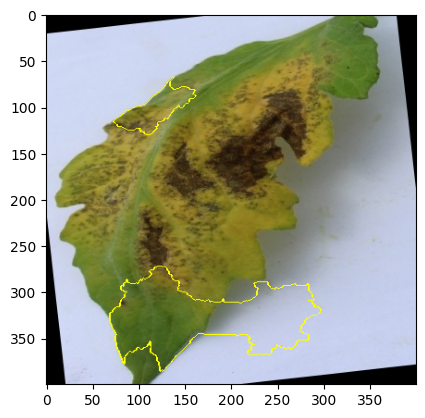

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

preprocss = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0) 
    return img_tensor.to(device), img

def predict_fn(images):
    model.eval()
    images = torch.stack([transforms.ToTensor()(img) for img in images]).to(device)
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()
    return probabilities
    

image_path = '/kaggle/input/pest-data/Testing_Data/verticulium wilt_Tomato/139tomato_valid_verticulium wilt.JPG'
try:
    img_tensor, original_img = preprocess_image(image_path)
    with torch.no_grad():
        model.eval()
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()

    print(probabilities)
    top5_prob, top5_catid = torch.topk(outputs, 5)
    print("Top-5 Predictions:")
    for i in range(top5_prob.size(1)):
        print(f"Class ID: {top5_catid[0][i].item()}, Probability: {top5_prob[0][i].item()*100:.2f}%")

    explainer = lime_image.LimeImageExplainer()

    top_class_index = top5_catid[0][0].item()
    print(top_class_index)
    explanation = explainer.explain_instance(
        image=np.array(original_img),
        classifier_fn=predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=10000
    )
    print(explanation.top_labels)

    temp, mask = explanation.get_image_and_mask(
        label=top_class_index,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    class_name = f"class_{top_class_index}"
    image_name = os.path.basename(image_path).split('.')[0]

    original_img_path = f"{class_name}_{image_name}_original.png"
    lime_explanation_path = f"{class_name}_{image_name}_lime.png"

    original_img.save(original_img_path)
    print(f"Original image saved at: {original_img_path}")

    lime_explanation_img = mark_boundaries(temp, mask)
    plt.imshow(lime_explanation_img)
    plt.imsave(lime_explanation_path, lime_explanation_img)
    print(f"LIME explanation saved at: {lime_explanation_path}")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")
